In [1]:
# Partially taken from https://fire.trainhub.eumetsat.int/docs/figure1_Sentinel-3_OLCI_RGB.html
# And the author of that got it from https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/251_Sentinel-3_OLCI_radiance_L1_load_browse.ipynb

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
# Load Login
with open('./login_data') as f:
    user, password = f.read().split('\n')

# Set up retrieval API
api = SentinelAPI(user, password, 'https://apihub.copernicus.eu/apihub')

In [2]:
# The filename tells the querry what we want:
# S3A : Sentinel satellite 3A
# OL_1_EFR :output during Earth Observation processing mode for Full Resolution at 300m spatial resolution
#   OL: OLCI / EFR___: Datatype ID 
# Next we have _202 indicating the decade and * to allow all with these parameters to be returned
# We also specify a footprint for our search area -> Which is a recantgle outlining the netherlands
# We also specify cloudcover to get nicer data
footprint = read_geojson('./search_area.geojson')
products = api.query(footprint,platformname = 'Sentinel-3',
                     filename='S3A_OL_1_EFR____2023*',
                     )

Querying products:  26%|##5       | 100/386 [00:00<?, ?product/s]

# Cloud Cover is always massive and this product doesnt have cloud cover percentage data 
# Could preselect with the more processed products, but for now just grabbed a product from the API site

In [22]:
# We will use sort according to size and then download the first dataset that is not in the Long Term Archive (These must be requested 30 min in advance)
try:
    df = api.to_dataframe(products).sort_values(['size'], ascending=[True])
except:
    df = api.to_dataframe(products)
    print('Size not specified --> Querry didnt give any results')
# Need to try several itmes some products wont download
count = 0 
for i in range(len(df)):
    #Check if resource is online
    try:
        if api.is_online('{}'.format(df.index[i])):
            print(api.get_product_odata(df.index[i]))
            api.download('{}'.format(df.index[i]))
            #And break the i loop
            break
    except:
        print('Download Failed')
        count += 1
        if count == 5:
            break
    else: pass

print('The File Name is {}'.format(df.iloc[i]['filename']))

{'id': '356d0b9b-ecb2-4662-b285-a2be02e35572', 'title': 'S3A_OL_1_EFR____20230102T092644_20230102T092814_20230103T100808_0090_094_036_1980_PS1_O_NT_003', 'size': 405093023, 'md5': '3a0d73ba87125549d8882c43d467d67e', 'date': datetime.datetime(2023, 1, 2, 9, 26, 43, 826000), 'footprint': 'POLYGON((4.79279 52.459,5.80563 52.3972,6.81369 52.3273,7.8146 52.2492,8.82111 52.1617,9.8188 52.0663,10.8116 51.9625,11.7975 51.8507,12.7797 51.7302,13.7544 51.6018,14.7298 51.4696,15.6975 51.3243,16.6571 51.1742,17.6085 51.0111,18.5559 50.8429,19.4937 50.6649,20.4246 50.4833,21.3505 50.2927,22.2674 50.0951,23.1782 49.8898,24.6716 52.452,26.3398 54.9998,25.3317 55.2263,24.3116 55.4443,23.2826 55.6532,22.2367 55.8535,21.1889 56.0472,20.1236 56.2304,19.0516 56.4069,17.9721 56.5683,16.8776 56.7239,15.7789 56.8641,14.6684 56.9999,13.5528 57.1256,12.4351 57.2404,11.3042 57.3459,10.1675 57.4412,9.02006 57.5266,7.87957 57.6008,6.72942 57.6649,5.57177 57.7193,5.18492 55.0873,4.79279 52.459))', 'url': "https://

Download Failed
{'id': '4f44b33b-6ab2-4cf3-ad3e-43cacfa9164e', 'title': 'S3A_OL_1_EFR____20230101T095256_20230101T095425_20230102T103404_0089_094_022_1980_PS1_O_NT_003', 'size': 410068498, 'md5': 'eb554e08754d0b37b2c13f20ad032134', 'date': datetime.datetime(2023, 1, 1, 9, 52, 55, 794000), 'footprint': 'POLYGON((-1.75133 52.4589,-0.735732 52.3969,0.270304 52.327,1.27071 52.2489,2.27532 52.1616,3.27348 52.0661,4.26629 51.9623,5.25299 51.8504,6.23546 51.7298,7.20981 51.6015,8.18647 51.469,9.15364 51.3237,10.1131 51.1736,11.0643 51.0105,12.0116 50.8424,12.949 50.6644,13.8796 50.4827,14.8058 50.2921,15.7227 50.0944,16.6337 49.8891,19.7454 54.9279,18.7396 55.1539,17.7206 55.3717,16.6934 55.5803,15.6492 55.7804,14.6031 55.9738,13.5399 56.1568,12.4697 56.3331,11.3922 56.4943,10.2999 56.6498,9.20202 56.7899,8.09314 56.9257,6.97912 57.0514,5.8585 57.1666,4.73755 57.2714,3.60251 57.3667,2.45823 57.452,1.32018 57.5263,0.17249 57.5906,-0.983495 57.6451,-1.75133 52.4589))', 'url': "https://apihub.co

In [8]:
# Uncompress the package
import zipfile
#filename = df.iloc[i]['filename']
with zipfile.ZipFile(filename.replace('.SEN3','.zip')) as z:
    z.extractall()

In [10]:
# As the above variables take up significant amounts of ram we remove htem
id = df.iloc[i]['uuid']
del df, products

In [9]:
import os
print('Data products downloaded')
print(os.listdir(filename))

Data products downloaded
['Oa18_radiance.nc', 'instrument_data.nc', 'Oa15_radiance.nc', 'tie_meteo.nc', 'Oa08_radiance.nc', 'Oa01_radiance_unc.nc', 'Oa12_radiance_unc.nc', 'Oa12_radiance.nc', 'Oa05_radiance_unc.nc', 'Oa04_radiance.nc', 'Oa10_radiance_unc.nc', 'Oa09_radiance_unc.nc', 'Oa10_radiance.nc', 'xfdumanifest.xml', 'Oa19_radiance_unc.nc', 'Oa15_radiance_unc.nc', 'Oa03_radiance_unc.nc', 'Oa16_radiance.nc', 'Oa11_radiance_unc.nc', 'Oa04_radiance_unc.nc', 'Oa05_radiance.nc', 'Oa18_radiance_unc.nc', 'Oa08_radiance_unc.nc', 'Oa14_radiance_unc.nc', 'geo_coordinates.nc', 'Oa02_radiance.nc', 'Oa03_radiance.nc', 'tie_geo_coordinates.nc', 'Oa09_radiance.nc', 'qualityFlags.nc', 'Oa20_radiance.nc', 'Oa13_radiance.nc', 'Oa02_radiance_unc.nc', 'Oa06_radiance_unc.nc', 'Oa20_radiance_unc.nc', 'Oa21_radiance_unc.nc', 'Oa13_radiance_unc.nc', 'Oa06_radiance.nc', 'Oa11_radiance.nc', 'Oa16_radiance_unc.nc', 'Oa17_radiance_unc.nc', 'Oa07_radiance.nc', 'removed_pixels.nc', 'time_coordinates.nc', 'tie_

In [12]:

odata = api.get_product_odata(id,full=True)
import glob
from netCDF4 import Dataset
import xarray as xr
olci_xr = xr.open_dataset(filename+'/'+os.listdir(filename)[0])
# Get some info on the dataset
olci_xr


<xarray.Dataset>
Dimensions:        (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    Oa18_radiance  (rows, columns) float32 ...
Attributes: (12/17)
    absolute_orbit_number:  26146
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-05-03T11:45:41Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.13
    start_time:             2023-05-03T09:49:45.844520Z
    stop_time:              2023-05-03T09:52:45.768287Z
    title:                  OLCI Level 1b Product, Radiance Oa18 Data Set

In [13]:
# Now we will load all channels at once
olci_xr_mf = xr.open_mfdataset(filename+'/*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    ...             ...
    Oa16_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa17_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa18_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa19_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa20_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa21_radiance  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
Attributes: (12/17)
    absolute_orbit_number:  26146
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-05-03T11:45:41Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.13
    start_time:             2023-05-03T09:49:45.844520Z
    stop_time:              2023-05-03T09:52:45.768287Z
    title:                  OLCI Level 1b Product, Radiance Oa01 Data Set

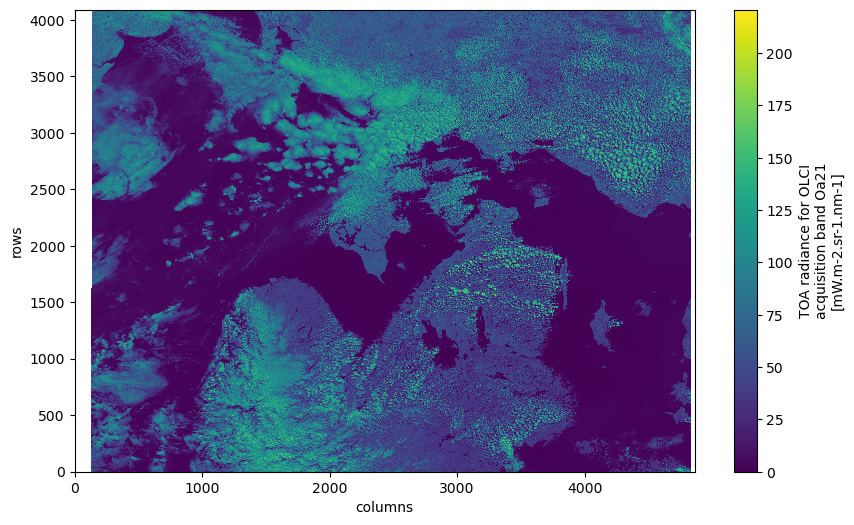

In [14]:
# Lets make a plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa21_radiance'].plot.imshow()

In [15]:
# Now we georeference
olci_geo_coords = xr.open_dataset(filename+'/geo_coordinates.nc')
olci_geo_coords


<xarray.Dataset>
Dimensions:    (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes: (12/17)
    absolute_orbit_number:  26146
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2023-05-03T11:45:41Z
    ...                     ...
    references:             S3IPF PDS 004.1 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.13
    start_time:             2023-05-03T09:49:45.844520Z
    stop_time:              2023-05-03T09:52:45.768287Z
    title:                  OLCI Level 1b Product, Geo Coordinates Data Set

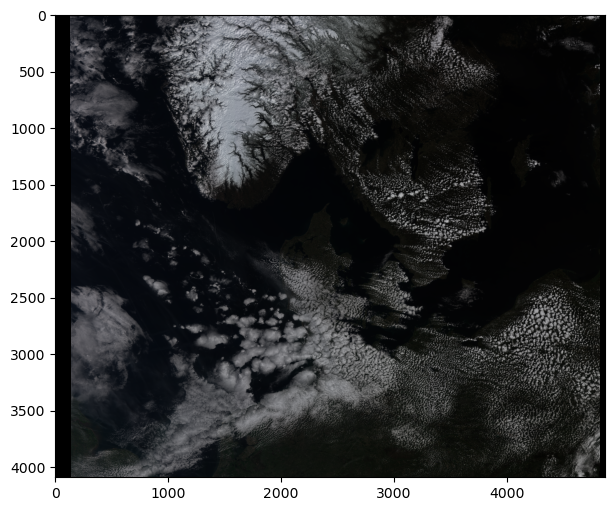

In [16]:
import numpy as np
# Channel combination for true color would be R:Oa08, G:Oa06, B: Oa04
def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))
red = normalize(red)
green = normalize(green)
blue = normalize(blue)
rgb = np.dstack((red, green, blue))

fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

In [17]:
# Now lets visualize the true color composite with geolocation

mesh_rgb = rgb[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as composite.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()
    ax.set_extent([longitude.min(), longitude.max(), latitude.min(), latitude.max()]) # Mediterranean

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

/home/felix/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/felix/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/felix/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


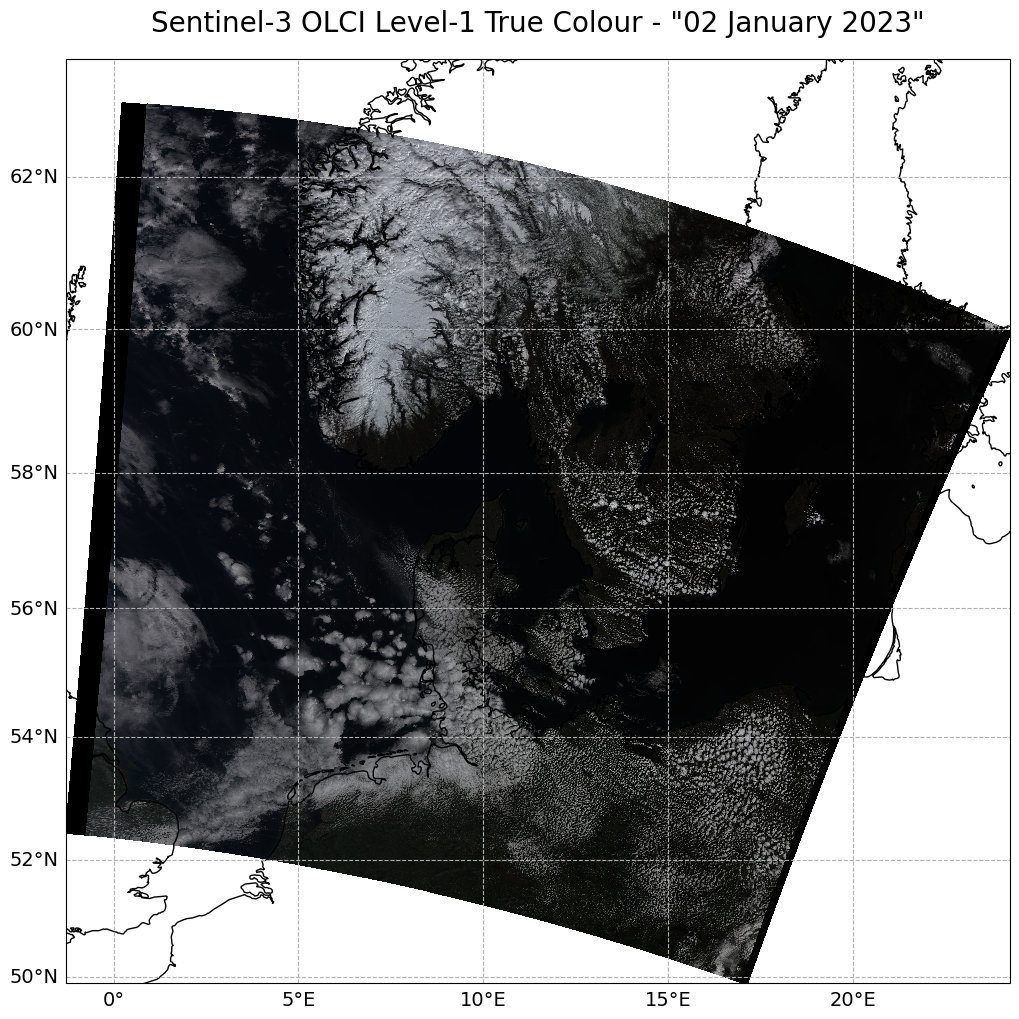

In [19]:
lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data


visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Colour - "02 January 2023"')


## The bands correspond to:

In [30]:
import requests
import pandas as pd
import tabulate

url = 'https://sentinel.esa.int/web/sentinel/user-guides/sentinel-3-olci/resolutions/radiometric'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1].iloc[:,0:3]
print(tabulate.tabulate(df))

--  ----  -------------  ----------
 0  Band  λ centre (nm)  Width (nm)
 1  Oa01  400            15
 2  Oa02  412.5          10
 3  Oa03  442.5          10
 4  Oa04  490            10
 5  Oa05  510            10
 6  Oa06  560            10
 7  Oa07  620            10
 8  Oa08  665            10
 9  Oa09  673.75         7.5
10  Oa10  681.25         7.5
11  Oa11  708.75         10
12  Oa12  753.75         7.5
13  Oa13  761.25         2.5
14  Oa14  764.375        3.75
15  Oa15  767.5          2.5
16  Oa16  778.75         15
17  Oa17  865            20
18  Oa18  885            10
19  Oa19  900            10
20  Oa20  940            20
21  Oa21  1020           40
--  ----  -------------  ----------
